In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/Data Analyst/Điểm thi đại học/data

/content/drive/My Drive/Data Analyst/Điểm thi đại học/data


In [ ]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

## I. Clean score

In [ ]:
score = pd.read_csv('./diemthi2020.csv')
score.head()

,Unnamed: 0,Dia,GDCD,Hoa,Li,Ma_mon_ngoai_ngu,Ngoai_ngu,Sinh,Su,Toan,Van,sbd
0,0,7.00,6.50,NaN,NaN,N1,4.2,NaN,4.75,6.4,6.75,18014547
1,1,7.75,7.75,NaN,NaN,N1,2.8,NaN,3.75,7.6,6.00,18014530
2,2,6.50,NaN,NaN,NaN,NaN,NaN,NaN,4.00,4.8,4.75,18014521
3,3,8.00,9.50,NaN,NaN,N1,5.8,NaN,8.25,8.0,7.00,18014517
4,4,NaN,NaN,8.5,8.0,N1,4.0,5.0,NaN,8.2,6.50,18014523


In [ ]:
# Drop column
score.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
# Process the column "sbd"
score['sbd'] = score['sbd'].astype(str)

In [ ]:
def add_zero(x):
    if len(x) == 7:
        return '0' + x
    return x
        
score['sbd'] = score['sbd'].apply(lambda x: add_zero(x))

## II. Match code provinces with name

In [ ]:
!pip install geopandas

     |████████████████████████████████| 972kB 2.8MB/s 
     |████████████████████████████████| 6.5MB 15.0MB/s 
     |████████████████████████████████| 14.8MB 180kB/s 


In [ ]:
import geopandas as gpd
map_df = gpd.read_file('./diaphantinh.geojson')
map_df.head()

,gid,code,ten_tinh,geometry
0,1,AD01,An Giang,"MULTIPOLYGON (((105.11524 10.95566, 105.11463 ..."
1,2,AD01,Bà Rịa -Vũng Tàu,"MULTIPOLYGON (((106.08110 8.57754, 106.08069 8..."
2,3,AD01,Bắc Giang,"MULTIPOLYGON (((106.16542 21.62022, 106.16925 ..."
3,4,AD01,Bắc Kạn,"MULTIPOLYGON (((105.74420 22.73519, 105.74624 ..."
4,5,AD01,Bạc Liêu,"MULTIPOLYGON (((105.32591 9.60004, 105.32755 9..."


In [ ]:
# Fix some typo errors
map_df.loc[44, 'ten_tinh'] = 'Quảng Bình'
map_df.loc[31, 'ten_tinh'] = 'Kiên Giang'
map_df.loc[12, 'ten_tinh'] = 'Cần Thơ'

In [ ]:
code_provinces = ['51', '52', '18', '11', '60', '19', '56', '37', '44', '43', '47', '61', '55',
                  '06', '04', '40', '63', '62', '48', '50', '38', '05', '24', '01', '30', '21',
                  '03', '64', '23', '22', '41', '54', '36', '07', '42', '10', '08', '49', '25',
                  '29', '27', '45', '15', '39', '31', '34', '35', '17', '32', '59', '14', '46',
                  '26', '12', '28', '33', '53', '02', '58', '09', '57', '16', '13']

In [ ]:
# Create a dictionary to map
mapping = {code_provinces[i]: map_df['ten_tinh'].unique().tolist()[i] for i in range(len(code_provinces))}

In [ ]:
# Drop Da Nang rows because of missing data
map_df.drop(14, inplace=True)
map_df.reset_index(drop=True, inplace=True)

In [ ]:
# Create columns of code and province
score['code'] = score['sbd'].str[:2]
score['province'] = score['code'].apply(lambda x: mapping[x])

In [ ]:
score.head()

,Dia,GDCD,Hoa,Li,Ma_mon_ngoai_ngu,Ngoai_ngu,Sinh,Su,Toan,Van,sbd,code,province
0,7.00,6.50,NaN,NaN,N1,4.2,NaN,4.75,6.4,6.75,18014547,18,Bắc Giang
1,7.75,7.75,NaN,NaN,N1,2.8,NaN,3.75,7.6,6.00,18014530,18,Bắc Giang
2,6.50,NaN,NaN,NaN,NaN,NaN,NaN,4.00,4.8,4.75,18014521,18,Bắc Giang
3,8.00,9.50,NaN,NaN,N1,5.8,NaN,8.25,8.0,7.00,18014517,18,Bắc Giang
4,NaN,NaN,8.5,8.0,N1,4.0,5.0,NaN,8.2,6.50,18014523,18,Bắc Giang


## III. Phân tích các môn ngoại ngữ

In [ ]:
language = score['Ma_mon_ngoai_ngu'].dropna().value_counts()
language = language.reset_index(name='count')
language

,index,count
0,N1,769085
1,N4,1259
2,N6,880
3,N3,680
4,N2,107
5,N5,87


In [ ]:
# Add cols of average score and the name of the subject
language['avg_score'] = np.nan
for i in range(len(language)):
    language.loc[i, 'avg_score'] = np.mean(score[score['Ma_mon_ngoai_ngu'] == language.loc[i, 'index']]['Ngoai_ngu'].dropna())

language['subject'] = np.nan
subjects = ['Tiếng Anh', 'Tiếng Trung', 'Tiếng Nhật', 'Tiếng Pháp', 'Tiếng Nga', 'Tiếng Đức']
for i in range(len(subjects)):
    language.loc[i, 'subject'] = subjects[i]

language

,index,count,avg_score,subject
0,N1,769085,4.558369,Tiếng Anh
1,N4,1259,6.995711,Tiếng Trung
2,N6,880,6.677500,Tiếng Nhật
3,N3,680,7.688824,Tiếng Pháp
4,N2,107,8.334579,Tiếng Nga
5,N5,87,7.202299,Tiếng Đức


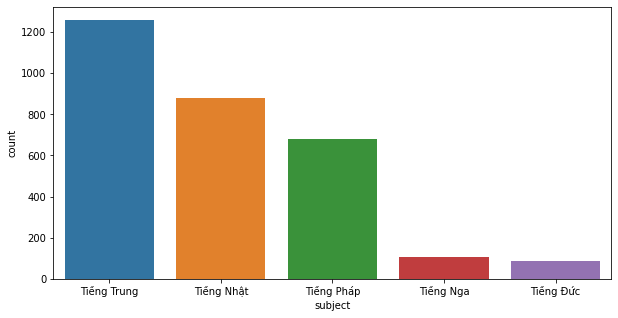

In [ ]:
# Number of candidates for each subjects
ax = plt.figure(figsize = (10, 5))
count_lang = language[['subject', 'count']].drop([0])
sns.barplot(x="subject", y="count", data=count_lang)

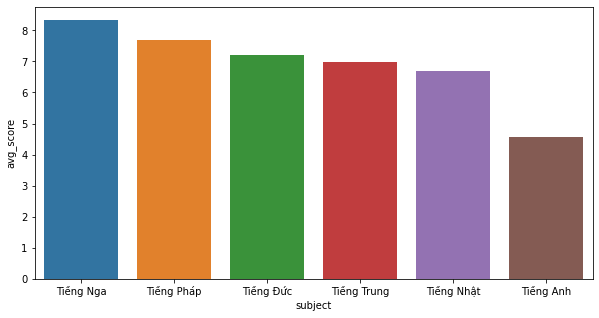

In [ ]:
# Average score of each subjects
ax = plt.figure(figsize = (10, 5))
language.sort_values(by=['avg_score'], ascending=False, inplace=True)
sns.barplot(x="subject", y="avg_score", data=language)

In [ ]:
# The number of students who take Chinese exam in each province
count_chinese = score[score['Ma_mon_ngoai_ngu'] == 'N4'].groupby(['province']).size().reset_index(name='chinese_count')
count_chinese.sort_values(by=['chinese_count'], ascending=False).head()

,province,chinese_count
26,Lào Cai,255
35,Quảng Ninh,173
15,Hà Nội,160
38,TP. Hồ Chí Minh,136
51,Đồng Nai,103


In [ ]:
# merge map_df with count_chinese df
merged = map_df.merge(count_chinese, how='left', left_on="ten_tinh", right_on="province")
merged.drop(columns=['province'], inplace=True)
merged.fillna(0, inplace=True)
merged.head()

,gid,code,ten_tinh,geometry,chinese_count
0,1,AD01,An Giang,"MULTIPOLYGON (((105.11524 10.95566, 105.11463 ...",0.0
1,2,AD01,Bà Rịa -Vũng Tàu,"MULTIPOLYGON (((106.08110 8.57754, 106.08069 8...",2.0
2,3,AD01,Bắc Giang,"MULTIPOLYGON (((106.16542 21.62022, 106.16925 ...",39.0
3,4,AD01,Bắc Kạn,"MULTIPOLYGON (((105.74420 22.73519, 105.74624 ...",2.0
4,5,AD01,Bạc Liêu,"MULTIPOLYGON (((105.32591 9.60004, 105.32755 9...",0.0


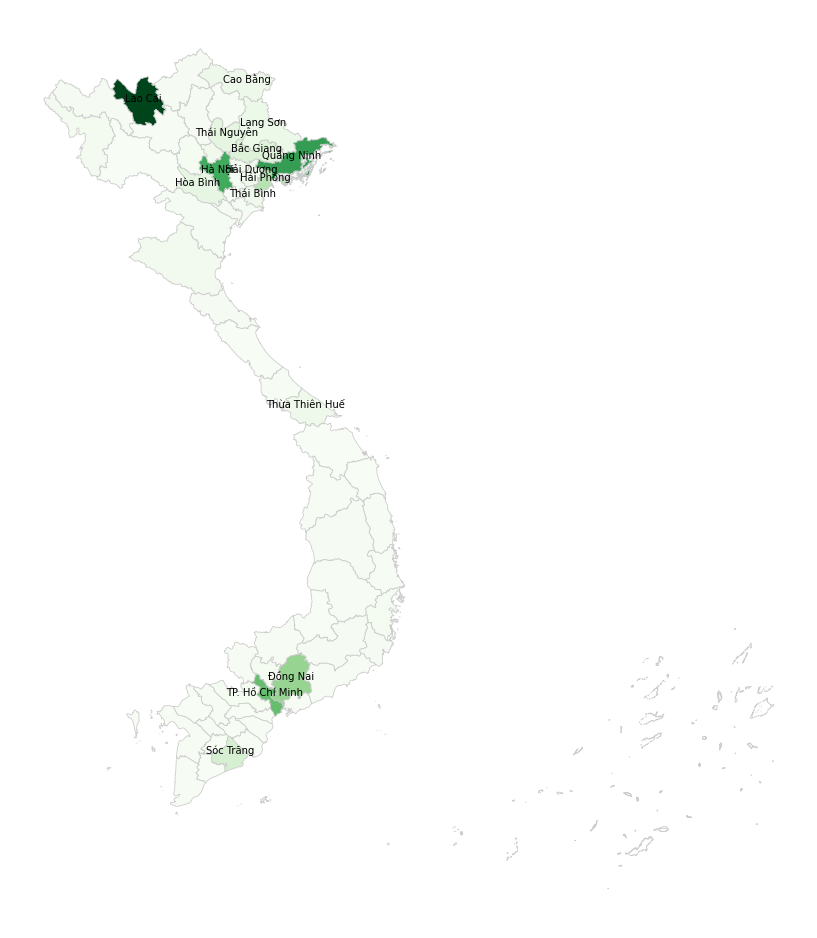

In [ ]:
# set the value column that will be visualised
variable = 'chinese_count'

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(50, 17))

# remove the axis
ax.axis('off')

# create map
merged.plot(column=variable, cmap='Greens', linewidth=0.8, ax=ax, edgecolor='0.8')

# Add Labels
merged['coords'] = merged['geometry'].apply(lambda x: x.representative_point().coords[:])
merged['coords'] = [coords[0] for coords in merged['coords']]
merged.sort_values(by=['chinese_count'], ascending=False, inplace=True)
for idx, row in merged[:15].iterrows():
    plt.annotate(s=row['ten_tinh'], xy=row['coords'],horizontalalignment='center')

## IV. Điểm trung bình các môn

In [ ]:
# The number of candidates who take Math exam in each province
count_math = score[score['Toan'].notna()].groupby(['province']).size().reset_index(name='math_count')
count_math.sort_values(by=['math_count'], ascending=False).head()

,province,math_count
17,Hà Nội,78641
45,TP. Hồ Chí Minh,74203
46,Thanh Hóa,34506
33,Nghệ An,30910
60,Đồng Nai,28157


In [ ]:
# The number of candidates who have score of Math >= 9 in each province
count_math9 = score[score['Toan'] >= 9].groupby(['province']).size().reset_index(name='math9_count')
count_math9.sort_values(by=['math9_count'], ascending=False).head()

,province,math9_count
17,Hà Nội,10029
45,TP. Hồ Chí Minh,6395
32,Nam Định,3269
46,Thanh Hóa,2907
33,Nghệ An,2719


In [ ]:
# The average Math score in each province
var_math = score[score['Toan'].notna()].groupby(['province'])['Toan'].var().reset_index(name='var_math')
var_math.sort_values(by=['var_math'], ascending=False).head()

,province,var_math
46,Thanh Hóa,4.452264
41,Quảng Ninh,4.117617
19,Hòa Bình,4.060485
15,Hà Giang,3.855036
48,Thái Nguyên,3.847474


In [ ]:
# The average Math score in each province
avg_math = score[score['Toan'].notna()].groupby(['province'])['Toan'].mean().reset_index(name='avg_math')
avg_math.sort_values(by=['avg_math'], ascending=False).head()

,province,avg_math
32,Nam Định,7.633317
45,TP. Hồ Chí Minh,7.363012
2,Bình Dương,7.296680
16,Hà Nam,7.263524
47,Thái Bình,7.244245


In [ ]:
# merge many df
merged = map_df.merge(count_math, how='left', left_on="ten_tinh", right_on="province")
merged.drop(columns=['province'], inplace=True)
merged = merged.merge(count_math9, how='left', left_on="ten_tinh", right_on="province")
merged.drop(columns=['province'], inplace=True)
merged = merged.merge(avg_math, how='left', left_on="ten_tinh", right_on="province")
merged.drop(columns=['province'], inplace=True)
merged = merged.merge(var_math, how='left', left_on="ten_tinh", right_on="province")
merged.drop(columns=['province'], inplace=True)
#merged.fillna(0, inplace=True)
merged.head()

,gid,code,ten_tinh,geometry,math_count,math9_count,avg_math,var_math
0,1,AD01,An Giang,"MULTIPOLYGON (((105.11524 10.95566, 105.11463 ...",15149,697,6.918133,2.106392
1,2,AD01,Bà Rịa -Vũng Tàu,"MULTIPOLYGON (((106.08110 8.57754, 106.08069 8...",11403,778,7.193142,2.071474
2,3,AD01,Bắc Giang,"MULTIPOLYGON (((106.16542 21.62022, 106.16925 ...",19245,1548,6.666750,3.106376
3,4,AD01,Bắc Kạn,"MULTIPOLYGON (((105.74420 22.73519, 105.74624 ...",2810,43,5.434235,3.162302
4,5,AD01,Bạc Liêu,"MULTIPOLYGON (((105.32591 9.60004, 105.32755 9...",5553,293,6.959842,2.024576


In [ ]:
merged['math9_pct'] = merged['math9_count']/merged['math_count']
merged.sort_values(by=['math9_pct'], ascending=False)

,gid,code,ten_tinh,geometry,math_count,math9_count,avg_math,var_math,math9_pct
37,39,AD01,Nam Định,"MULTIPOLYGON (((106.10474 19.89106, 106.10382 ...",18627,3269,7.633317,2.081280,0.175498
51,53,AD01,Thái Bình,"MULTIPOLYGON (((106.60477 20.27758, 106.60447 ...",19564,2663,7.244245,2.722614,0.136117
22,24,AD01,Hà Nội,"MULTIPOLYGON (((105.82965 21.37512, 105.83067 ...",78641,10029,7.011597,3.546785,0.127529
5,6,AD01,Bắc Ninh,"MULTIPOLYGON (((106.03246 21.22488, 106.03217 ...",14592,1826,7.119956,2.928125,0.125137
21,23,AD01,Hà Nam,"MULTIPOLYGON (((106.03325 20.67910, 106.03327 ...",8548,1042,7.263524,2.530781,0.121900
...,...,...,...,...,...,...,...,...,...
57,59,AD01,Trà Vinh,"MULTIPOLYGON (((106.33031 10.01151, 106.35479 ...",7879,164,6.128417,2.696586,0.020815
32,34,AD01,Lai Châu,"MULTIPOLYGON (((103.33303 22.80670, 103.33399 ...",3256,56,5.876843,2.531765,0.017199
3,4,AD01,Bắc Kạn,"MULTIPOLYGON (((105.74420 22.73519, 105.74624 ...",2810,43,5.434235,3.162302,0.015302
20,22,AD01,Hà Giang,"MULTIPOLYGON (((105.32929 23.38417, 105.33323 ...",5596,85,4.503645,3.855036,0.015189


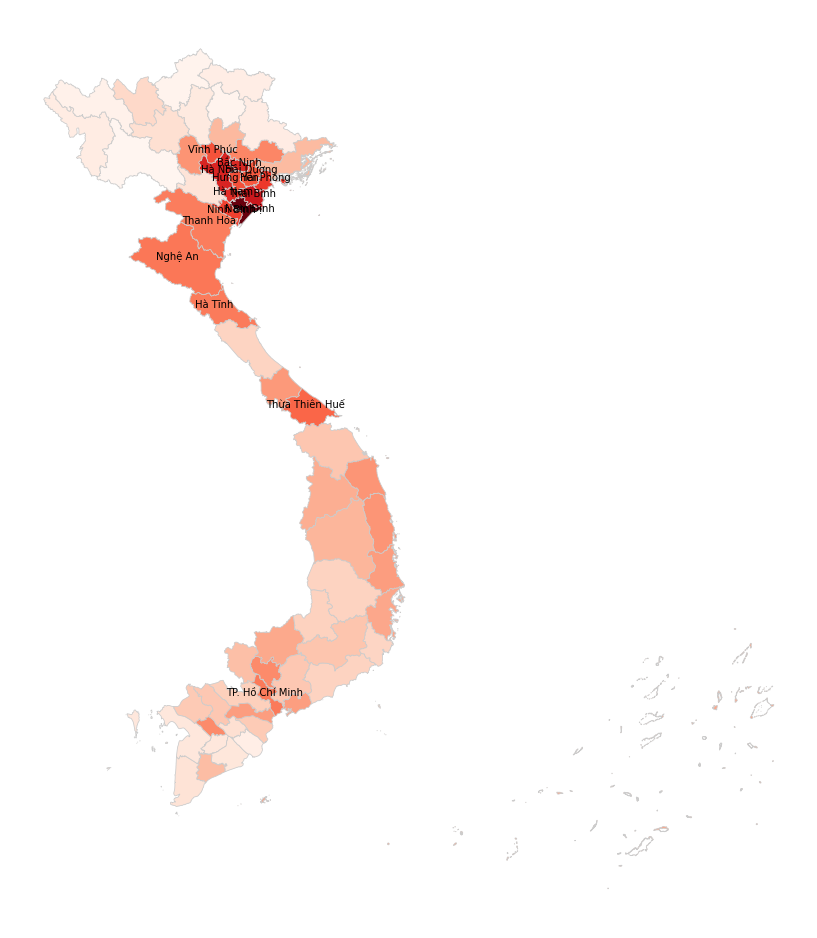

In [ ]:
# set the value column that will be visualised
variable = 'math9_pct'

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(50, 17))

# remove the axis
ax.axis('off')

# create map
merged.plot(column=variable, cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8')

# Add Labels
merged['coords'] = merged['geometry'].apply(lambda x: x.representative_point().coords[:])
merged['coords'] = [coords[0] for coords in merged['coords']]
merged.sort_values(by=['math9_pct'], ascending=False, inplace=True)
for idx, row in merged[:15].iterrows():
    plt.annotate(s=row['ten_tinh'], xy=row['coords'],horizontalalignment='center')

In [ ]:
# The number of candidates who take Literature exam in each province
count_literature = score[score['Van'].notna()].groupby(['province']).size().reset_index(name='literature_count')
count_literature.sort_values(by=['literature_count'], ascending=False).head()

,province,literature_count
17,Hà Nội,77748
45,TP. Hồ Chí Minh,72646
46,Thanh Hóa,34200
33,Nghệ An,30279
60,Đồng Nai,27921


In [ ]:
# The number of candidates who have score of Literature >= 9 in each province
count_literature9 = score[score['Van'] >= 9].groupby(['province']).size().reset_index(name='literature9_count')
count_literature9.sort_values(by=['literature9_count'], ascending=False).head()

,province,literature9_count
0,An Giang,1471
17,Hà Nội,1457
45,Thanh Hóa,932
32,Nghệ An,609
13,Cần Thơ,534


In [ ]:
# The average Literature score in each province
var_literature = score[score['Van'].notna()].groupby(['province'])['Van'].var().reset_index(name='var_literature')
var_literature.sort_values(by=['var_literature'], ascending=False).head()

,province,var_literature
41,Quảng Ninh,2.451544
15,Hà Giang,2.245895
11,Cao Bằng,2.184227
31,Lạng Sơn,2.077169
40,Quảng Ngãi,2.042474


In [ ]:
# The average Literature score in each province
avg_literature = score[score['Van'].notna()].groupby(['province'])['Van'].mean().reset_index(name='avg_literature')
avg_literature.sort_values(by=['avg_literature'], ascending=False).head()

,province,avg_literature
0,An Giang,7.615759
2,Bình Dương,7.281503
32,Nam Định,7.272736
61,Đồng Tháp,7.265716
43,Sóc Trăng,7.260543


In [ ]:
# merge many df
merged = map_df.merge(count_literature, how='left', left_on="ten_tinh", right_on="province")
merged.drop(columns=['province'], inplace=True)
merged = merged.merge(count_literature9, how='left', left_on="ten_tinh", right_on="province")
merged.drop(columns=['province'], inplace=True)
merged = merged.merge(avg_literature, how='left', left_on="ten_tinh", right_on="province")
merged.drop(columns=['province'], inplace=True)
merged = merged.merge(var_literature, how='left', left_on="ten_tinh", right_on="province")
merged.drop(columns=['province'], inplace=True)
#merged.fillna(0, inplace=True)
merged.head()

,gid,code,ten_tinh,geometry,literature_count,literature9_count,avg_literature,var_literature
0,1,AD01,An Giang,"MULTIPOLYGON (((105.11524 10.95566, 105.11463 ...",15069,1471.0,7.615759,1.087957
1,2,AD01,Bà Rịa -Vũng Tàu,"MULTIPOLYGON (((106.08110 8.57754, 106.08069 8...",11314,127.0,6.871082,1.187756
2,3,AD01,Bắc Giang,"MULTIPOLYGON (((106.16542 21.62022, 106.16925 ...",19080,18.0,6.534296,1.191055
3,4,AD01,Bắc Kạn,"MULTIPOLYGON (((105.74420 22.73519, 105.74624 ...",2815,16.0,5.918913,1.755695
4,5,AD01,Bạc Liêu,"MULTIPOLYGON (((105.32591 9.60004, 105.32755 9...",5444,28.0,6.947825,0.843188


In [ ]:
merged['literature9_pct'] = merged['literature9_count']/merged['literature_count']
merged.sort_values(by=['literature9_pct'], ascending=False)

,gid,code,ten_tinh,geometry,literature_count,literature9_count,avg_literature,var_literature,literature9_pct
0,1,AD01,An Giang,"MULTIPOLYGON (((105.11524 10.95566, 105.11463 ...",15069,1471.0,7.615759,1.087957,0.097618
12,13,AD01,Cần Thơ,"MULTIPOLYGON (((105.59811 10.23951, 105.60244 ...",10007,534.0,7.213692,1.248289,0.053363
48,50,AD01,Sóc Trăng,"MULTIPOLYGON (((105.90627 9.93254, 105.90919 9...",8380,380.0,7.260543,1.132375,0.045346
18,20,AD01,Đồng Tháp,"MULTIPOLYGON (((105.44963 10.95591, 105.45154 ...",13206,381.0,7.265716,0.994247,0.028851
53,55,AD01,Thanh Hóa,"MULTIPOLYGON (((105.82264 19.30695, 105.82084 ...",34200,932.0,7.049970,1.621757,0.027251
...,...,...,...,...,...,...,...,...,...
2,3,AD01,Bắc Giang,"MULTIPOLYGON (((106.16542 21.62022, 106.16925 ...",19080,18.0,6.534296,1.191055,0.000943
56,58,AD01,TP. Hồ Chí Minh,"MULTIPOLYGON (((106.96860 10.45353, 106.96735 ...",72646,64.0,6.743665,0.794083,0.000881
15,17,AD01,Đăk Nông,"MULTIPOLYGON (((107.85778 12.80281, 107.86036 ...",6089,5.0,6.032145,1.223896,0.000821
61,63,AD01,Yên Bái,"MULTIPOLYGON (((104.60800 22.29097, 104.60906 ...",7347,5.0,5.834626,1.585175,0.000681


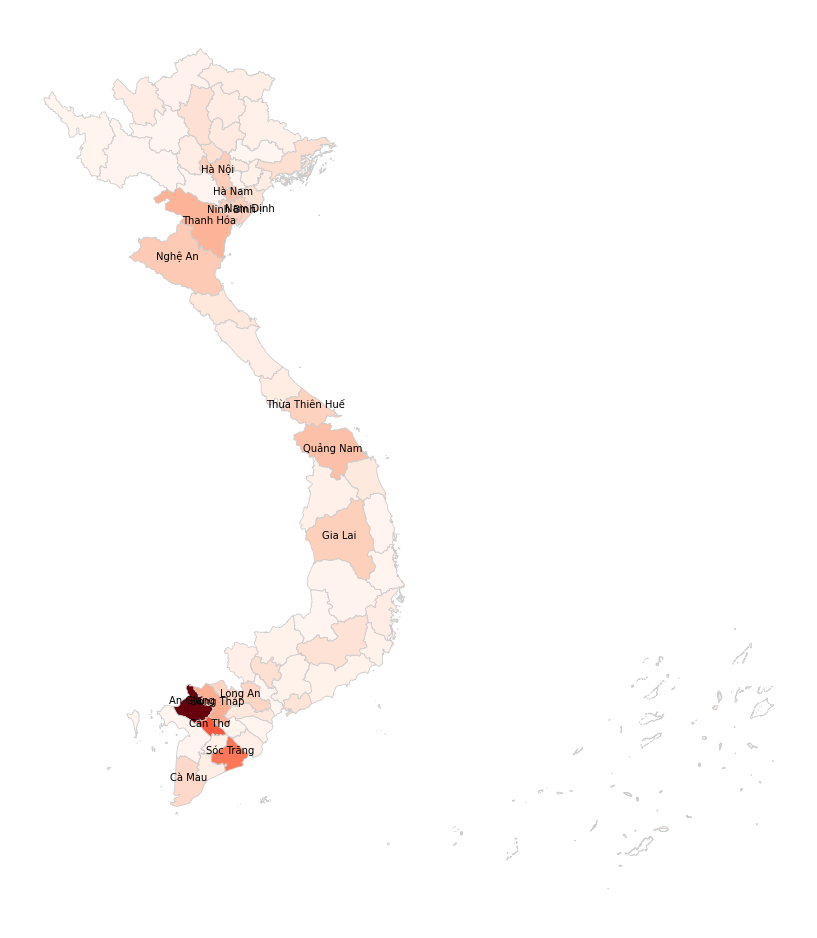

In [ ]:
# set the value column that will be visualised
variable = 'literature9_pct'

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(50, 17))

# remove the axis
ax.axis('off')

# create map
merged.plot(column=variable, cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8')

# Add Labels
merged['coords'] = merged['geometry'].apply(lambda x: x.representative_point().coords[:])
merged['coords'] = [coords[0] for coords in merged['coords']]
merged.sort_values(by=['literature9_pct'], ascending=False, inplace=True)
for idx, row in merged[:15].iterrows():
    plt.annotate(s=row['ten_tinh'], xy=row['coords'],horizontalalignment='center')

In [ ]:
# The number of candidates who take Eng exam in each province
count_eng = score[score['Ma_mon_ngoai_ngu'] == 'N1'].groupby(['province']).size().reset_index(name='eng_count')
count_eng.sort_values(by=['eng_count'], ascending=False).head()

,province,eng_count
17,Hà Nội,67282
45,TP. Hồ Chí Minh,65778
46,Thanh Hóa,31750
33,Nghệ An,28289
60,Đồng Nai,23034


In [ ]:
# The number of candidates who have score of Eng >= 9 in each province
count_eng9 = score[score['Ma_mon_ngoai_ngu'] == 'N1'][score['Ngoai_ngu'] >= 9].groupby(['province']).size().reset_index(name='eng9_count')
count_eng9.sort_values(by=['eng9_count'], ascending=False).head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,province,eng9_count
17,Hà Nội,3178
45,TP. Hồ Chí Minh,2582
22,Hải Phòng,447
33,Nghệ An,326
46,Thanh Hóa,305


In [ ]:
# The average Eng score in each province
var_eng = score[score['Ma_mon_ngoai_ngu'] == 'N1'].groupby(['province'])['Ngoai_ngu'].var().reset_index(name='var_eng')
var_eng.sort_values(by=['var_eng'], ascending=False).head()

,province,var_eng
17,Hà Nội,4.768619
22,Hải Phòng,3.638073
24,Khánh Hòa,3.414037
41,Quảng Ninh,3.409312
49,Thừa Thiên Huế,3.312216


In [ ]:
# The average Eng score in each province
avg_eng = score[score['Ma_mon_ngoai_ngu'] == 'N1'].groupby(['province'])['Ngoai_ngu'].mean().reset_index(name='avg_eng')
avg_eng.sort_values(by=['avg_eng'], ascending=False).head()

,province,avg_eng
45,TP. Hồ Chí Minh,5.853279
2,Bình Dương,5.499353
1,Bà Rịa -Vũng Tàu,5.273438
17,Hà Nội,5.157320
32,Nam Định,5.106658


In [ ]:
# merge many df
merged = map_df.merge(count_eng, how='left', left_on="ten_tinh", right_on="province")
merged.drop(columns=['province'], inplace=True)
merged = merged.merge(count_eng9, how='left', left_on="ten_tinh", right_on="province")
merged.drop(columns=['province'], inplace=True)
merged = merged.merge(avg_eng, how='left', left_on="ten_tinh", right_on="province")
merged.drop(columns=['province'], inplace=True)
merged = merged.merge(var_eng, how='left', left_on="ten_tinh", right_on="province")
merged.drop(columns=['province'], inplace=True)
#merged.fillna(0, inplace=True)
merged.head()

,gid,code,ten_tinh,geometry,eng_count,eng9_count,avg_eng,var_eng
0,1,AD01,An Giang,"MULTIPOLYGON (((105.11524 10.95566, 105.11463 ...",14266,120,4.912099,2.151179
1,2,AD01,Bà Rịa -Vũng Tàu,"MULTIPOLYGON (((106.08110 8.57754, 106.08069 8...",10052,248,5.273438,3.159796
2,3,AD01,Bắc Giang,"MULTIPOLYGON (((106.16542 21.62022, 106.16925 ...",16259,161,4.463903,2.562089
3,4,AD01,Bắc Kạn,"MULTIPOLYGON (((105.74420 22.73519, 105.74624 ...",2425,11,3.667464,2.026965
4,5,AD01,Bạc Liêu,"MULTIPOLYGON (((105.32591 9.60004, 105.32755 9...",5083,24,4.633366,2.038178


In [ ]:
merged['eng9_pct'] = merged['eng9_count']/merged['eng_count']
merged.sort_values(by=['eng9_pct'], ascending=False)

,gid,code,ten_tinh,geometry,eng_count,eng9_count,avg_eng,var_eng,eng9_pct
22,24,AD01,Hà Nội,"MULTIPOLYGON (((105.82965 21.37512, 105.83067 ...",67282,3178,5.157320,4.768619,0.047234
56,58,AD01,TP. Hồ Chí Minh,"MULTIPOLYGON (((106.96860 10.45353, 106.96735 ...",65778,2582,5.853279,3.132807,0.039253
25,27,AD01,Hải Phòng,"MULTIPOLYGON (((107.72800 20.12807, 107.71875 ...",16516,447,4.984233,3.638073,0.027065
1,2,AD01,Bà Rịa -Vũng Tàu,"MULTIPOLYGON (((106.08110 8.57754, 106.08069 8...",10052,248,5.273438,3.159796,0.024672
8,9,AD01,Bình Dương,"MULTIPOLYGON (((106.43608 11.50210, 106.44327 ...",9278,183,5.499353,2.554901,0.019724
...,...,...,...,...,...,...,...,...,...
26,28,AD01,Hậu Giang,"MULTIPOLYGON (((105.57910 9.98585, 105.58078 9...",5389,17,3.723696,1.884437,0.003155
32,34,AD01,Lai Châu,"MULTIPOLYGON (((103.33303 22.80670, 103.33399 ...",2635,8,3.892524,1.362689,0.003036
14,16,AD01,Đăk Lăk,"MULTIPOLYGON (((108.06956 13.40431, 108.07056 ...",12910,35,3.731681,2.056022,0.002711
11,12,AD01,Cà Mau,"MULTIPOLYGON (((104.87929 8.38103, 104.87884 8...",9184,24,4.122017,1.960487,0.002613


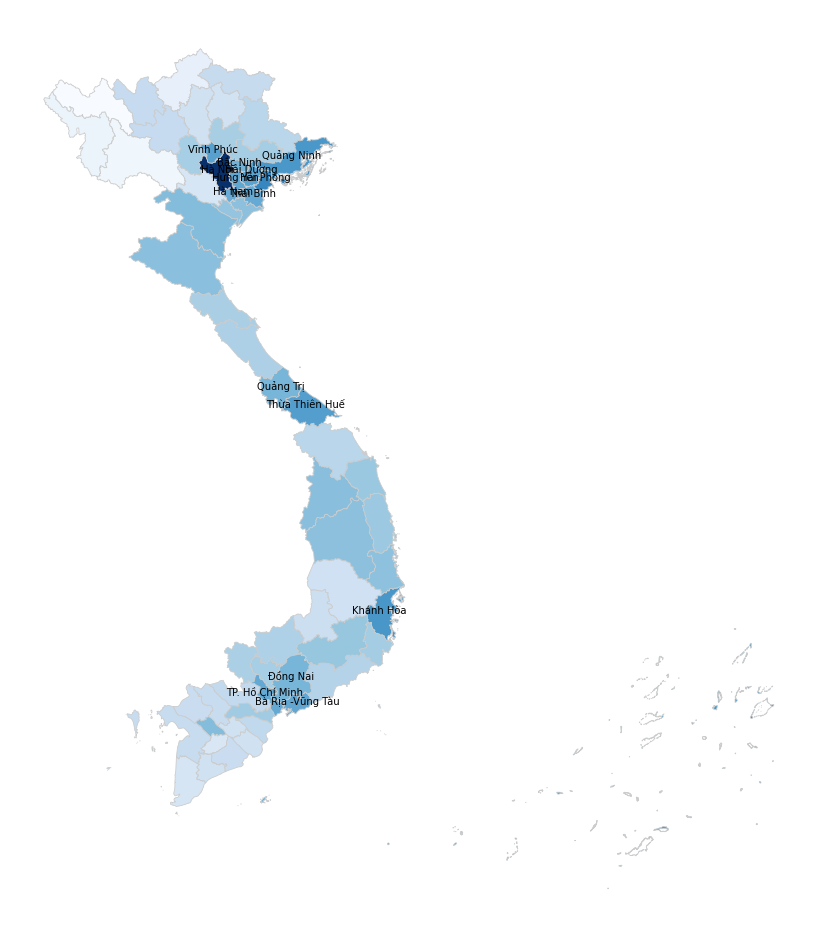

In [ ]:
# set the value column that will be visualised
variable = 'var_eng'

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(50, 17))

# remove the axis
ax.axis('off')

# create map
merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

# Add Labels
merged['coords'] = merged['geometry'].apply(lambda x: x.representative_point().coords[:])
merged['coords'] = [coords[0] for coords in merged['coords']]
merged.sort_values(by=['var_eng'], ascending=False, inplace=True)
for idx, row in merged[:15].iterrows():
    plt.annotate(s=row['ten_tinh'], xy=row['coords'],horizontalalignment='center')

In [ ]:
# The number of candidates who take History exam in each province
count_history = score[score['Su'].notna()].groupby(['province']).size().reset_index(name='history_count')
count_history.sort_values(by=['history_count'], ascending=False).head()

,province,history_count
17,Hà Nội,53797
45,TP. Hồ Chí Minh,30318
46,Thanh Hóa,24950
33,Nghệ An,22029
60,Đồng Nai,17949


In [ ]:
# The number of candidates who have score of History >= 9 in each province
count_history9 = score[score['Su'] >= 9].groupby(['province']).size().reset_index(name='history9_count')
count_history9.sort_values(by=['history9_count'], ascending=False).head()

,province,history9_count
17,Hà Nội,1063
46,Thanh Hóa,565
33,Nghệ An,474
45,TP. Hồ Chí Minh,463
36,Phú Thọ,447


In [ ]:
# The average History score in each province
var_history = score[score['Su'].notna()].groupby(['province'])['Su'].var().reset_index(name='var_history')
var_history.sort_values(by=['var_history'], ascending=False).head()

,province,var_history
11,Cao Bằng,3.114200
57,Điện Biên,3.056463
55,Vĩnh Phúc,2.890139
34,Ninh Bình,2.850661
18,Hà Tĩnh,2.836655


In [ ]:
# The average History score in each province
avg_history = score[score['Su'].notna()].groupby(['province'])['Su'].mean().reset_index(name='avg_history')
avg_history.sort_values(by=['avg_history'], ascending=False).head()

,province,avg_history
2,Bình Dương,5.910012
32,Nam Định,5.886718
0,An Giang,5.739920
16,Hà Nam,5.736184
34,Ninh Bình,5.729828


In [ ]:
# merge many df
merged = map_df.merge(count_history, how='left', left_on="ten_tinh", right_on="province")
merged.drop(columns=['province'], inplace=True)
merged = merged.merge(count_history9, how='left', left_on="ten_tinh", right_on="province")
merged.drop(columns=['province'], inplace=True)
merged = merged.merge(avg_history, how='left', left_on="ten_tinh", right_on="province")
merged.drop(columns=['province'], inplace=True)
merged = merged.merge(var_history, how='left', left_on="ten_tinh", right_on="province")
merged.drop(columns=['province'], inplace=True)
#merged.fillna(0, inplace=True)
merged.head()

,gid,code,ten_tinh,geometry,history_count,history9_count,avg_history,var_history
0,1,AD01,An Giang,"MULTIPOLYGON (((105.11524 10.95566, 105.11463 ...",9152,317,5.739920,2.629126
1,2,AD01,Bà Rịa -Vũng Tàu,"MULTIPOLYGON (((106.08110 8.57754, 106.08069 8...",5548,108,5.141673,2.391612
2,3,AD01,Bắc Giang,"MULTIPOLYGON (((106.16542 21.62022, 106.16925 ...",14534,291,5.257878,2.376383
3,4,AD01,Bắc Kạn,"MULTIPOLYGON (((105.74420 22.73519, 105.74624 ...",2576,99,5.380629,2.782832
4,5,AD01,Bạc Liêu,"MULTIPOLYGON (((105.32591 9.60004, 105.32755 9...",3411,112,5.651275,2.673920


In [ ]:
merged['history9_pct'] = merged['history9_count']/merged['history_count']
merged.sort_values(by=['history9_pct'], ascending=False)

,gid,code,ten_tinh,geometry,history_count,history9_count,avg_history,var_history,history9_pct
37,39,AD01,Nam Định,"MULTIPOLYGON (((106.10474 19.89106, 106.10382 ...",9302,424,5.886718,2.755880,0.045582
39,41,AD01,Ninh Bình,"MULTIPOLYGON (((105.79825 20.43953, 105.80129 ...",5924,255,5.729828,2.850661,0.043045
41,43,AD01,Phú Thọ,"MULTIPOLYGON (((105.11401 21.70583, 105.11601 ...",10925,447,5.576018,2.775356,0.040915
16,18,AD01,Điện Biên,"MULTIPOLYGON (((102.35845 22.48274, 102.35965 ...",4801,196,5.293689,3.056463,0.040825
21,23,AD01,Hà Nam,"MULTIPOLYGON (((106.03325 20.67910, 106.03327 ...",5718,227,5.736184,2.808559,0.039699
...,...,...,...,...,...,...,...,...,...
36,38,AD01,Long An,"MULTIPOLYGON (((105.81728 10.96027, 105.85563 ...",7041,90,5.099950,2.382738,0.012782
42,44,AD01,Phú Yên,"MULTIPOLYGON (((109.39067 12.82696, 109.39037 ...",6515,78,4.817613,2.225240,0.011972
57,59,AD01,Trà Vinh,"MULTIPOLYGON (((106.33031 10.01151, 106.35479 ...",5624,60,5.069257,2.205322,0.010669
20,22,AD01,Hà Giang,"MULTIPOLYGON (((105.32929 23.38417, 105.33323 ...",5057,52,4.533765,2.212257,0.010283


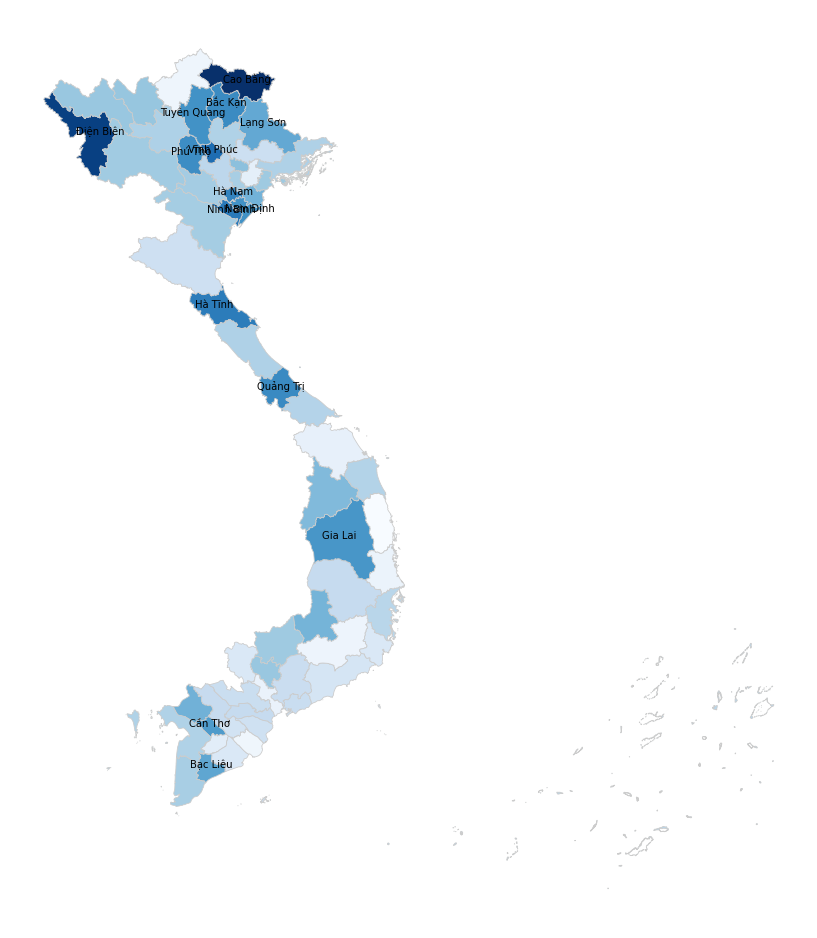

In [ ]:
# set the value column that will be visualised
variable = 'var_history'

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(50, 17))

# remove the axis
ax.axis('off')

# create map
merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

# Add Labels
merged['coords'] = merged['geometry'].apply(lambda x: x.representative_point().coords[:])
merged['coords'] = [coords[0] for coords in merged['coords']]
merged.sort_values(by=['var_history'], ascending=False, inplace=True)
for idx, row in merged[:15].iterrows():
    plt.annotate(s=row['ten_tinh'], xy=row['coords'],horizontalalignment='center')

In [ ]:
score.columns

Index(['Dia', 'GDCD', 'Hoa', 'Li', 'Ma_mon_ngoai_ngu', 'Ngoai_ngu', 'Sinh',
       'Su', 'Toan', 'Van', 'sbd', 'code', 'province'],
      dtype='object')

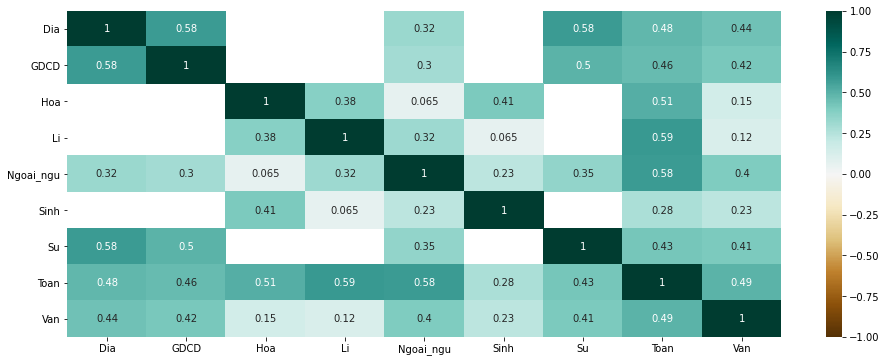

In [ ]:
plt.figure(figsize=(16, 6))
sns.heatmap(score[['Dia', 'GDCD', 'Hoa', 'Li', 'Ngoai_ngu', 'Sinh',
       'Su', 'Toan', 'Van']].corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')

## V. Điểm thi có liên quan đến tháng sinh hay k? (phần này làm vội nên đặt tên biến lung tung)

In [ ]:
# Read file csv
sg_score = pd.read_csv('./cleaned_data.csv')
sg_score.drop(columns=['Content'], inplace=True)
sg_score = sg_score[sg_score['Month_of_birth'] > 0]
sg_score.head()

,Name,Year_of_birth,Month_of_birth,Math,Literature,English,Physics,Chemistry,Biology,Ethics,History,Geometry,Social_science,Natural_science,French,Japanese,Chinese,Russian
0,PHẠM HOÀNG HƯƠNG ÁI,2002,11,6.6,6.25,5.2,NaN,NaN,NaN,7.25,5.75,7.00,6.67,NaN,NaN,NaN,NaN,NaN
1,ĐẶNG HUỲNH VĨNH AN,2002,12,8.2,7.75,7.0,NaN,NaN,NaN,8.50,7.00,7.25,7.58,NaN,NaN,NaN,NaN,NaN
2,LÂM NGUYỄN MỘNG THÙY AN,2001,4,6.8,6.75,6.0,NaN,NaN,NaN,8.25,4.75,7.75,6.92,NaN,NaN,NaN,NaN,NaN
3,LÊ TIÊU HOÀNG AN,2002,11,7.8,6.25,5.6,5.50,6.25,7.0,NaN,NaN,NaN,NaN,6.25,NaN,NaN,NaN,NaN
4,LƯ THUẬN AN,2002,1,6.4,6.50,8.2,6.75,6.25,5.5,NaN,NaN,NaN,NaN,6.17,NaN,NaN,NaN,NaN


In [ ]:
# The average Math score according to month of birth
math_birth = sg_score[sg_score['avg_score'].notna()].groupby(['first_letter'])['avg_score'].mean().reset_index(name='avg_score')
math_birth.head()

,first_letter,avg_score
0,a,6.829754
1,b,6.540527
2,c,6.694015
3,d,6.608824
4,e,6.202778


In [ ]:
sg_score['avg_score'] = sg_score[['Math', 'Literature', 'English']].mean(axis=1)

In [ ]:
# The number of candidates who take History exam in each province
count_english = sg_score[sg_score['avg_score'].notna()].groupby(['first_letter']).size().reset_index(name='english_count')
count_english.sort_values(by=['english_count'], ascending=False).head()

,first_letter,english_count
19,t,18009
13,n,9450
7,h,8907
3,d,5308
10,k,4309


In [ ]:
# The number of candidates who have score of History >= 9 in each province
count_english9 = sg_score[sg_score['avg_score'] >= 8].groupby(['first_letter']).size().reset_index(name='english9_count')
count_english9.sort_values(by=['english9_count'], ascending=False).head()

,first_letter,english9_count
16,t,1780
10,n,1080
6,h,886
0,a,539
3,d,498


In [ ]:
df = count_english9.merge(count_english, how='inner', left_on='first_letter', right_on='first_letter')
df = df.merge(math_birth, how='inner', left_on='first_letter', right_on='first_letter')
df['pct'] = df['english9_count']/df['english_count']
df = df.sort_values(by=['english_count'], ascending=False)[:-5]

In [ ]:
df = df.sort_values(by=['first_letter'])

In [ ]:
df

,first_letter,english9_count,english_count,avg_score,pct
0,a,539,4241,6.829754,0.127093
1,b,129,1630,6.540527,0.079141
2,c,190,1629,6.694015,0.116636
3,d,498,5308,6.608824,0.093821
5,g,71,566,6.758216,0.125442
6,h,886,8907,6.639900,0.099472
7,k,438,4309,6.692411,0.101648
8,l,431,4162,6.645904,0.103556
9,m,288,2605,6.776351,0.110557
10,n,1080,9450,6.730553,0.114286


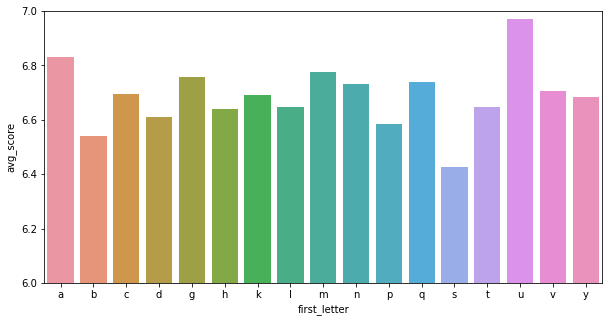

In [ ]:
# Average score according to each month of birth
fig, ax = plt.subplots(figsize=(10,5))
ax.set_ylim(6, 7)
sns.barplot(x="first_letter", y="avg_score", data=df)


In [ ]:
# Filter the first letter of every names
sg_score['first_letter'] = sg_score['Name'].str.split(' ').apply(lambda x: x[-1][0])

def remove_accent(x):
    s1 = u'ÀÁÂÃÈÉÊÌÍÒÓÔÕÙÚÝàáâãèéêìíòóôõùúýĂăĐđĨĩŨũƠơƯưẠạẢảẤấẦầẨẩẪẫẬậẮắẰằẲẳẴẵẶặẸẹẺẻẼẽẾếỀềỂểỄễỆệỈỉỊịỌọỎỏỐốỒồỔổỖỗỘộỚớỜờỞởỠỡỢợỤụỦủỨứỪừỬửỮữỰựỲỳỴỵỶỷỸỹ'
    s0 = u'AAAAEEEIIOOOOUUYaaaaeeeiioooouuyAaDdIiUuOoUuAaAaAaAaAaAaAaAaAaAaAaAaEeEeEeEeEeEeEeEeIiIiOoOoOoOoOoOoOoOoOoOoOoOoUuUuUuUuUuUuUuYyYyYyYy'
    if x in s1:
        return s0[s1.index(x)].lower()
    return x.lower()

sg_score['first_letter'] = sg_score['first_letter'].apply(remove_accent)

In [ ]:
# The average Math score according to first letter of name
math_name = sg_score[sg_score['Math'].notna()].groupby(['first_letter'])['Math'].mean().reset_index(name='avg_math')
math_name.head()

,first_letter,avg_math
0,a,7.474307
1,b,7.261491
2,c,7.363446
3,d,7.350189
4,e,6.822222


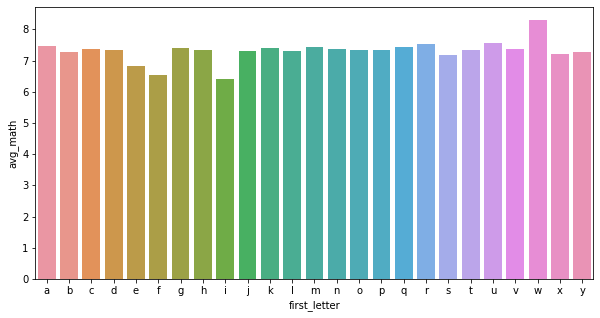

In [ ]:
# Average score according to each month of birth
ax = plt.figure(figsize = (10, 5))
sns.barplot(x="first_letter", y="avg_math", data=math_name)